# Predicting House Sale Prices

In [1]:
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold,cross_val_score, cross_val_predict

In [2]:
df = pd.read_csv('AmesHousing.tsv', delimiter='\t')
df

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,2926,923275080,80,RL,37.0,7937,Pave,NaN,IR1,Lvl,...,0,NaN,GdPrv,NaN,0,3,2006,WD,Normal,142500
2926,2927,923276100,20,RL,NaN,8885,Pave,NaN,IR1,Low,...,0,NaN,MnPrv,NaN,0,6,2006,WD,Normal,131000
2927,2928,923400125,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,132000
2928,2929,924100070,20,RL,77.0,10010,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2006,WD,Normal,170000


## Feature Engineering

In [3]:
## For all the columns, drop the columns contain more than 5% missing values

null_series = df.isnull().sum()
df = df[null_series[null_series <= 0.05*len(df)].index]
df.isnull().sum()

Order             0
PID               0
MS SubClass       0
MS Zoning         0
Lot Area          0
                 ..
Mo Sold           0
Yr Sold           0
Sale Type         0
Sale Condition    0
SalePrice         0
Length: 71, dtype: int64

In [4]:
## For the text columns, drop columns contains 1 or more missing values
null_text_series = df.select_dtypes(include=['object']).isnull().sum()
df = df.drop(df[null_text_series[null_text_series > 0].index], axis=1)
df.isnull().sum()

Order             0
PID               0
MS SubClass       0
MS Zoning         0
Lot Area          0
                 ..
Mo Sold           0
Yr Sold           0
Sale Type         0
Sale Condition    0
SalePrice         0
Length: 64, dtype: int64

In [5]:
## For the numerical columns, fill in the missing values with mode of that columns
null_num_series = df.select_dtypes(include=['int', 'float']).isnull().sum()
fixable_num_series = null_num_series[(null_num_series > 0) & (null_num_series < 0.05*len(df))]
fixable_num_series

Mas Vnr Area      23
BsmtFin SF 1       1
BsmtFin SF 2       1
Bsmt Unf SF        1
Total Bsmt SF      1
Bsmt Full Bath     2
Bsmt Half Bath     2
Garage Cars        1
Garage Area        1
dtype: int64

In [6]:
replacement_values = df[fixable_num_series.index].mode().to_dict(orient='records')[0]
replacement_values

{'Mas Vnr Area': 0.0,
 'BsmtFin SF 1': 0.0,
 'BsmtFin SF 2': 0.0,
 'Bsmt Unf SF': 0.0,
 'Total Bsmt SF': 0.0,
 'Bsmt Full Bath': 0.0,
 'Bsmt Half Bath': 0.0,
 'Garage Cars': 2.0,
 'Garage Area': 0.0}

In [7]:
df = df.fillna(replacement_values)

In [8]:
df.isnull().sum().value_counts()

0    64
dtype: int64

### Explore new features

To better predict the house sales, the features such as 'Yr Sold', 'Year Built' and 'Year Remod/Add' are meaningless. Instead, creating new features by calculating the differece bewteen them, for example, the total years houses have been sold, the total years houses have been remodeled would provide more information on predicting the house sale prices.

In [9]:
years_sold = df['Yr Sold'] - df['Year Built']
years_sold[years_sold < 0]

2180   -1
dtype: int64

In [10]:
years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
years_since_remod[years_since_remod < 0]

1702   -1
2180   -2
2181   -1
dtype: int64

In [11]:
df['Years Before Sale'] = years_sold
df['Years Since Remod'] = years_since_remod

df = df.drop([1702, 2180, 2181], axis=0)

df = df.drop(['Year Built','Year Remod/Add'], axis=1)

Other than that, looking at the [data documentation](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt), let's drop columns that aren't useful for ML and leak data about the final sale prices.

In [12]:
## Drop columns that aren't useful for ML
df = df.drop(['PID', 'Order'], axis=1)

## Drop columns that leak info about the final sale prices
df = df.drop(['Mo Sold', 'Sale Condition', 'Sale Type', 'Yr Sold'], axis=1)

In [13]:
df

,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,SalePrice,Years Before Sale,Years Since Remod
0,20,RL,31770,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,...,210,62,0,0,0,0,0,215000,50,50
1,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,140,0,0,0,120,0,0,105000,49,49
2,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,...,393,36,0,0,0,0,12500,172000,52,52
3,20,RL,11160,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,...,0,0,0,0,0,0,0,244000,42,42
4,60,RL,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,...,212,34,0,0,0,0,0,189900,13,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,80,RL,7937,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,...,120,0,0,0,0,0,0,142500,22,22
2926,20,RL,8885,Pave,IR1,Low,AllPub,Inside,Mod,Mitchel,...,164,0,0,0,0,0,0,131000,23,23
2927,85,RL,10441,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,...,80,32,0,0,0,0,700,132000,14,14
2928,20,RL,10010,Pave,Reg,Lvl,AllPub,Inside,Mod,Mitchel,...,240,38,0,0,0,0,0,170000,32,31


## Feature Selection

In [14]:
numerical_df = df.select_dtypes(include=['integer','float'])
numerical_df.head()

,MS SubClass,Lot Area,Overall Qual,Overall Cond,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,SalePrice,Years Before Sale,Years Since Remod
0,20,31770,6,5,112.0,639.0,0.0,441.0,1080.0,1656,...,210,62,0,0,0,0,0,215000,50,50
1,20,11622,5,6,0.0,468.0,144.0,270.0,882.0,896,...,140,0,0,0,120,0,0,105000,49,49
2,20,14267,6,6,108.0,923.0,0.0,406.0,1329.0,1329,...,393,36,0,0,0,0,12500,172000,52,52
3,20,11160,7,5,0.0,1065.0,0.0,1045.0,2110.0,2110,...,0,0,0,0,0,0,0,244000,42,42
4,60,13830,5,5,0.0,791.0,0.0,137.0,928.0,928,...,212,34,0,0,0,0,0,189900,13,12


Take a look at the correlation heatmap matrix of numerical features in the training data to see which features correlate strongly with the target column 'SalePrice'.

In [15]:
abs_corr_coeffs = numerical_df.corr()['SalePrice'].abs().sort_values()
abs_corr_coeffs

BsmtFin SF 2         0.006127
Misc Val             0.019273
3Ssn Porch           0.032268
Bsmt Half Bath       0.035875
Low Qual Fin SF      0.037629
Pool Area            0.068438
MS SubClass          0.085128
Overall Cond         0.101540
Screen Porch         0.112280
Kitchen AbvGr        0.119760
Enclosed Porch       0.128685
Bedroom AbvGr        0.143916
Bsmt Unf SF          0.182751
Lot Area             0.267520
2nd Flr SF           0.269601
Bsmt Full Bath       0.276258
Half Bath            0.284871
Open Porch SF        0.316262
Wood Deck SF         0.328183
BsmtFin SF 1         0.439284
Fireplaces           0.474831
TotRms AbvGrd        0.498574
Mas Vnr Area         0.506983
Years Since Remod    0.534985
Full Bath            0.546118
Years Before Sale    0.558979
1st Flr SF           0.635185
Garage Area          0.641425
Total Bsmt SF        0.644012
Garage Cars          0.648361
Gr Liv Area          0.717596
Overall Qual         0.801206
SalePrice            1.000000
Name: Sale

In [16]:
## Take 0.4 as threshold, we only look into features with correlation 0.4 or more 
abs_corr_coeffs[abs_corr_coeffs > 0.4]

BsmtFin SF 1         0.439284
Fireplaces           0.474831
TotRms AbvGrd        0.498574
Mas Vnr Area         0.506983
Years Since Remod    0.534985
Full Bath            0.546118
Years Before Sale    0.558979
1st Flr SF           0.635185
Garage Area          0.641425
Total Bsmt SF        0.644012
Garage Cars          0.648361
Gr Liv Area          0.717596
Overall Qual         0.801206
SalePrice            1.000000
Name: SalePrice, dtype: float64

In [17]:
df = df.drop(abs_corr_coeffs[abs_corr_coeffs < 0.4].index, axis=1)

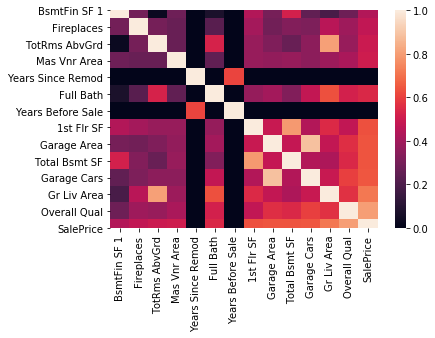

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
corr_columns = abs_corr_coeffs[abs_corr_coeffs > 0.4].index
corr = numerical_df[corr_columns].corr()
sns.heatmap(corr,vmin=0, vmax=1)

We can also see that there are two pair of features are strongly correlated: 
<br>
- **Gr Live Area** and **TotRms AbvGrd** 
- **Garage Cars** and **Garage Area**
<br>

Known from the [data documentation](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt), each pair of those columns reflects very similar information. Therefore, let's drop the **TotRms AbvGrd** and **Garage Cars**, because **Gr Liv Area** and **Garage Area** are continuous variables that provide better information on training the model.

In [19]:
df = df.drop(columns=['TotRms AbvGrd', 'Garage Cars'])
df

,MS Zoning,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,...,Gr Liv Area,Full Bath,Kitchen Qual,Functional,Fireplaces,Garage Area,Paved Drive,SalePrice,Years Before Sale,Years Since Remod
0,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,...,1656,1,TA,Typ,2,528.0,P,215000,50,50
1,RH,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,...,896,1,TA,Typ,0,730.0,Y,105000,49,49
2,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,...,1329,1,Gd,Typ,0,312.0,Y,172000,52,52
3,RL,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,...,2110,2,Ex,Typ,2,522.0,Y,244000,42,42
4,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,...,1629,2,TA,Typ,1,482.0,Y,189900,13,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,RL,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,Norm,Norm,...,1003,1,TA,Typ,0,588.0,Y,142500,22,22
2926,RL,Pave,IR1,Low,AllPub,Inside,Mod,Mitchel,Norm,Norm,...,902,1,TA,Typ,0,484.0,Y,131000,23,23
2927,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,...,970,1,TA,Typ,0,0.0,Y,132000,14,14
2928,RL,Pave,Reg,Lvl,AllPub,Inside,Mod,Mitchel,Norm,Norm,...,1389,1,TA,Typ,1,418.0,Y,170000,32,31


### Convert columns between numerical and catergorical

First, we need to convert those numerical columns that has catergorical meaning into categorical ones, since they don't have any semantic meaning.

In [20]:
## Here are the numerical columns but indeed has catergorical meaning
nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]

cat_cols = []

for col in nominal_features:
    if col in df.columns:
        cat_cols.append(col)
cat_cols

['MS Zoning',
 'Street',
 'Land Contour',
 'Lot Config',
 'Neighborhood',
 'Condition 1',
 'Condition 2',
 'Bldg Type',
 'House Style',
 'Roof Style',
 'Roof Matl',
 'Exterior 1st',
 'Exterior 2nd',
 'Foundation',
 'Heating',
 'Central Air']

Second, for those categorical columns, we want to check the number of unique values. If the column has too many unique values, it is not ideal to dummy that column since we have to add back those dummy columns to the data.

In [21]:
## Check the number of unique values of each categorical columns
uniqueness_count = df[cat_cols].apply(lambda x: len(x.value_counts()))

## Drop the columns that have unique values more than 10
ten_more = uniqueness_count[uniqueness_count > 10].index
df = df.drop(ten_more, axis=1)
df

,MS Zoning,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Condition 1,Condition 2,Bldg Type,...,Gr Liv Area,Full Bath,Kitchen Qual,Functional,Fireplaces,Garage Area,Paved Drive,SalePrice,Years Before Sale,Years Since Remod
0,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Norm,Norm,1Fam,...,1656,1,TA,Typ,2,528.0,P,215000,50,50
1,RH,Pave,Reg,Lvl,AllPub,Inside,Gtl,Feedr,Norm,1Fam,...,896,1,TA,Typ,0,730.0,Y,105000,49,49
2,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Norm,Norm,1Fam,...,1329,1,Gd,Typ,0,312.0,Y,172000,52,52
3,RL,Pave,Reg,Lvl,AllPub,Corner,Gtl,Norm,Norm,1Fam,...,2110,2,Ex,Typ,2,522.0,Y,244000,42,42
4,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Norm,Norm,1Fam,...,1629,2,TA,Typ,1,482.0,Y,189900,13,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,RL,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,Norm,Norm,1Fam,...,1003,1,TA,Typ,0,588.0,Y,142500,22,22
2926,RL,Pave,IR1,Low,AllPub,Inside,Mod,Norm,Norm,1Fam,...,902,1,TA,Typ,0,484.0,Y,131000,23,23
2927,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,1Fam,...,970,1,TA,Typ,0,0.0,Y,132000,14,14
2928,RL,Pave,Reg,Lvl,AllPub,Inside,Mod,Norm,Norm,1Fam,...,1389,1,TA,Typ,1,418.0,Y,170000,32,31


In [22]:
for col in ten_more:
    cat_cols.remove(col)
cat_cols

['MS Zoning',
 'Street',
 'Land Contour',
 'Lot Config',
 'Condition 1',
 'Condition 2',
 'Bldg Type',
 'House Style',
 'Roof Style',
 'Roof Matl',
 'Foundation',
 'Heating',
 'Central Air']

Third, we also have to drop the categorical columns have a few unique values but more than 95% of the values in the column belong to a specific category, because this would reduce variability in the data for the model training.

In [23]:
## Find and remove the low variance columns
low_var_cols=[]
num_row = len(df)
for col in cat_cols:
    unique_values = df[col].value_counts()
    for value in unique_values:
        if value > 0.95*num_row:
            low_var_cols.append(col)
            cat_cols.remove(col)


print(low_var_cols)
print(cat_cols)

['Street', 'Condition 2', 'Roof Matl', 'Heating']
['MS Zoning', 'Land Contour', 'Lot Config', 'Condition 1', 'Bldg Type', 'House Style', 'Roof Style', 'Foundation', 'Central Air']


In [24]:
## Convert the remaining columns into categorical ones
for col in cat_cols:
    df[col] = df[col].astype('category')
    
## Get dummy for the categorical columns
df = pd.concat([
    df,pd.get_dummies(df.select_dtypes(include=['category']))
], axis=1).drop(cat_cols, axis=1)

df

,Street,Lot Shape,Utilities,Land Slope,Condition 2,Overall Qual,Roof Matl,Mas Vnr Area,Exter Qual,Exter Cond,...,Roof Style_Mansard,Roof Style_Shed,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Central Air_N,Central Air_Y
0,Pave,IR1,AllPub,Gtl,Norm,6,CompShg,112.0,TA,TA,...,0,0,0,1,0,0,0,0,0,1
1,Pave,Reg,AllPub,Gtl,Norm,5,CompShg,0.0,TA,TA,...,0,0,0,1,0,0,0,0,0,1
2,Pave,IR1,AllPub,Gtl,Norm,6,CompShg,108.0,TA,TA,...,0,0,0,1,0,0,0,0,0,1
3,Pave,Reg,AllPub,Gtl,Norm,7,CompShg,0.0,Gd,TA,...,0,0,0,1,0,0,0,0,0,1
4,Pave,IR1,AllPub,Gtl,Norm,5,CompShg,0.0,TA,TA,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,Pave,IR1,AllPub,Gtl,Norm,6,CompShg,0.0,TA,TA,...,0,0,0,1,0,0,0,0,0,1
2926,Pave,IR1,AllPub,Mod,Norm,5,CompShg,0.0,TA,TA,...,0,0,0,1,0,0,0,0,0,1
2927,Pave,Reg,AllPub,Gtl,Norm,5,CompShg,0.0,TA,TA,...,0,0,0,0,1,0,0,0,0,1
2928,Pave,Reg,AllPub,Mod,Norm,5,CompShg,0.0,TA,TA,...,0,0,0,1,0,0,0,0,0,1


## Model Fitting and Cross Validation

Let's add a parameter k to controls the type of cross validation that occurs.

* When k equals 0, perform **holdout validation**
* When k equals 1, perform **simple cross validation**
* When k is greater than 1, perform **k-fold cross validation** 

In [25]:
def train_and_test(df, k=0):

    df = df.select_dtypes(include=['integer','float'])
    features = df.columns.drop('SalePrice')
    target = 'SalePrice'
    lr = linear_model.LinearRegression()
    
    if k == 0:
        train = df[:1460]
        test = df[1460:]

        lr.fit(train[features], train[target])
        predictions = lr.predict(test[features])

        mse = mean_squared_error(test[target], predictions)
        rmse = np.sqrt(mse)
        
        return rmse
        
    elif k == 1:
        df = df.sample(frac=1)
        
        fold_one = df[:1460]
        fold_two = df[1460:]
        
        ## Train on fold_one and test on fold_two
        lr.fit(fold_one[features], fold_one[target])
        predictions = lr.predict(fold_two[features])
        
        mse_two = mean_squared_error(fold_two[target], predictions)
        rmse_two = np.sqrt(mse_two)
    
        ## Train on fold_two and test on fold_one
        lr.fit(fold_two[features], fold_two[target])
        predictions = lr.predict(fold_one[features])

        mse_one = mean_squared_error(fold_one[target], predictions)
        rmse_one = np.sqrt(mse_one)
        
        avg_rmse = np.mean([rmse_one, rmse_two])
        
        return avg_rmse
    
    else:
        kf = KFold(n_splits=k, shuffle=True, random_state=1)
#         rmse_values = []
#         lr.fit(train[features], train[target])
#         for train_index, test_index in kf.split(df):
#             train = df.iloc[train_index]
#             test = df.iloc[test_index]
#             predictions = lr.predict(test[features])
#             mse = mean_squared_error(test[target], predictions)
#             rmse_values.append(rmse)
#         avg_rmse = np.mean(rmse_values)
            
        mses = cross_val_score(lr, df[features], df[target], scoring="neg_mean_squared_error", cv=kf)
        predictions = cross_val_predict(lr, df[features], df[target], cv=kf)

        rmses = np.sqrt(np.abs(mses))
        rmse = np.mean(rmses)
        std = np.std(rmses)
        
        return rmse, std, predictions

In [26]:
rmse = train_and_test(df, k=4)

rmse

(31462.66462290328,
 4449.227459817353,
 array([202224.12210828, 105128.88348526, 171568.62133341, ...,
        128432.06032885, 170447.27428967, 246706.43307981]))

### The effect of different k values on the final result 

In [27]:
rmses = []
stds = []
for k in range(2,12):
    rmse, std, predictions = train_and_test(df, k=k)
    rmses.append(rmse)
    stds.append(std)
print(rmses)
print(stds)

[31615.39570572422, 31442.900666694957, 31462.66462290328, 31187.51779465679, 31123.84301529257, 31242.097823634896, 31226.22821910717, 31118.558157866297, 31039.13841426316, 30953.701283385944]
[2109.572001107732, 3364.8500320171916, 4449.227459817353, 5248.605784487628, 5715.253152941872, 5367.9140781581145, 5755.3650342533865, 6146.639442371484, 6621.206740688983, 6933.876706673315]


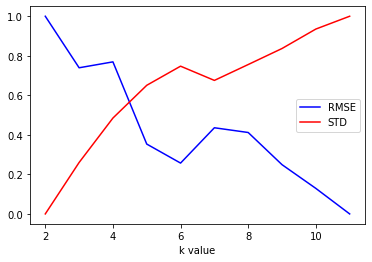

In [28]:
#Get the result of k-fold cross validation
x = range(2, 12)
#RMSE (rescaling into (0,1))
y = (rmses - min(rmses))/(max(rmses) - min(rmses))
plt.plot(x,y, label = 'RMSE', color='blue')
plt.xlabel('k value')

#STD (rescaling into (0,1))
y = (stds - min(stds))/(max(stds) - min(stds))
plt.plot(x,y, label = 'STD', color='red')
plt.legend()

As we can see in the graph, it is a trade-off between RMSE and STD. We want to have the lowest values for both of them, which seems to be the case when k=4.

Finally, Let's have a look at the difference between predictions and the real values graphically when k value is 4.

Text(0.5, 1.0, 'Distribution of Error for k = 4')

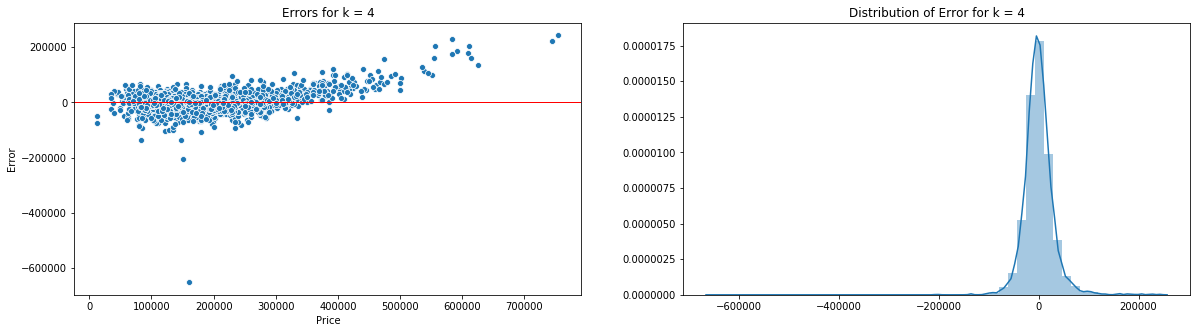

In [29]:
#Scatter plot
fig, axes = plt.subplots(ncols=2, figsize=(20,5))
x = df['SalePrice']
y = np.array(df['SalePrice']) - np.array(predictions)
sns.scatterplot(x = x, y = y, ax = axes[0])
axes[0].axhline(linewidth=1, color='r')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Error')
axes[0].set_title('Errors for k = 4')
sns.distplot(y, ax = axes[1])
axes[1].set_title('Distribution of Error for k = 4')

We can see that the model predicts well when the houses price are below $400000.

## Conclusion

In this project, Feature Engineering and Feature Selection were implemented for training better the Linear Regression model, and cross validation was also used to validate the model's performance. Also, the best k value (k = 4) for the K-Fold cross validation was explored to get the better result.